In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import cv2

import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import save_image

c:\Anaconda\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Anaconda\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Data handling constants
TRAIN_DIR = './data_map_cutouts/train3' 
BATCH_SIZE = 32

In [3]:
# The actual Data handling

# Some transformations to apply to the dataset
to_tensor = transforms.ToTensor()                       # Convert it to a tensor
random_flips_v = transforms.RandomVerticalFlip(0.5)     # Flip it vertically with prob. 0.5
random_flips_h = transforms.RandomHorizontalFlip(0.5)   # Flip it horizontally with prob 0.5
to_grayscale = transforms.Grayscale(1)                  # Convert the image to a single channel image

# Composing the transformations
transform = transforms.Compose([
    to_grayscale,
    to_tensor,
    random_flips_h,
    random_flips_v
])

# Creating the dataLoader
train_dir = pathlib.Path(TRAIN_DIR)                         # The directory 
train_data = datasets.ImageFolder(root      = train_dir,    # The dataset
                                  transform = transform)
train_dataLoader = DataLoader(dataset = train_data,         # The dataLoader (batches and shuffles the data)
                     batch_size = BATCH_SIZE, 
                     shuffle    = True,
                     drop_last  = True)


Shape of images from dataLoader: torch.Size([32, 1, 128, 128])


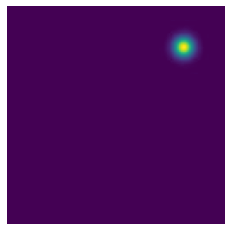

In [4]:
# Sampling from the dataset
images, labels = next(iter(train_dataLoader))
print("Shape of images from dataLoader:", images.shape)

# Displaying a sample input image
plt.imshow(images[0, 0, :, :].detach().cpu().numpy())
plt.axis('off')
plt.show()

## Model

In [5]:
'''
Creating a nn Module to allow us to reshape data using the nn.view() function
'''
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape
        # print(shape)

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)

'''
Class that contains the model
'''
class VAE(nn.Module):
    # Initializing the model
    def __init__(self, latent_dim) -> None:
        super().__init__()

        # Saving the latent dim for future use (especially in encoding and sampling)
        self.latent_dim = latent_dim

        # Usage of CUDA if it is available
        self.cuda = torch.cuda.is_available
        self.device = torch.device("cuda" if self.cuda else "cpu")

        # Creating the encoder (this is from the paper arXiv:2101.11181v1, with the exception that the latent-size is controllable)
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels   = 1,
                out_channels  = 256,
                kernel_size   = 3,
                stride        = 2,
                padding       = 1
            ),
            nn.ReLU(
                # negative_slope=0.2,
                inplace=True),
            
            nn.BatchNorm2d(num_features = 256,
                           eps          = 0.01,
                           momentum = 0.9),

            nn.Conv2d(
                in_channels   = 256,
                out_channels  = 128,
                kernel_size   = 3,
                stride        = 2,
                padding       = 1
            ),
            nn.ReLU(
                # negative_slope=0.2,
                inplace=True),

            nn.BatchNorm2d(num_features = 128,
                           eps          = 0.01,
                           momentum     = .9),

            nn.Conv2d(
                in_channels   = 128,
                out_channels  = 64,
                kernel_size   = 3,
                stride        = 2,
                padding       = 1
            ),
            nn.ReLU(
                # negative_slope=0.2,
                inplace=True),

            nn.BatchNorm2d(num_features = 64,
                           eps          = 0.01,
                           momentum     = .9),
            nn.Flatten(),
            nn.Linear(in_features  = 64*16**2, 
                      out_features = 1024),
                      
            nn.Linear(in_features  = 1024, 
                      out_features = 2*latent_dim),
        ).to(self.device)
        
        # Creating the decoder (this is from the paper arXiv:2101.11181v1, with the exception that the latent-size is controllable)
        self.decoder = nn.Sequential(
            nn.Linear(in_features  = latent_dim, 
                      out_features = 2048),
            Reshape((32, 8, 8)),
            nn.BatchNorm2d(num_features = 32,
                           eps          = 0.01, 
                           momentum     = .9),

            nn.ConvTranspose2d(in_channels  = 32,
                      out_channels = 128,
                      kernel_size  = 3,
                      stride       = 2,
                      padding      = 1,
                      output_padding = 1
                      ),
            nn.ReLU(
                # negative_slope = 0.2,
                inplace        = True
            ),
            nn.BatchNorm2d(num_features = 128,
                           eps          = 0.01, 
                           momentum     = .9),

            nn.ConvTranspose2d(in_channels  = 128,
                      out_channels = 64,
                      kernel_size  = 3,
                      stride       = 2,
                      padding      = 1,
                      output_padding = 1
                      ),
            nn.ReLU(
                # negative_slope = 0.2,
                inplace        = True
            ),                        
            nn.BatchNorm2d(num_features = 64,
                           eps          = 0.01, 
                           momentum     = .9),
            
            nn.ConvTranspose2d(in_channels  = 64,
                      out_channels = 32,
                      kernel_size  = 3,
                      stride       = 2,
                      padding      = 1,
                      output_padding = 1
                      ),
            nn.ReLU(
                # negative_slope = 0.2,
                inplace        = True
            ),                        
            nn.BatchNorm2d(num_features = 32,
                           eps          = 0.01, 
                           momentum     = .9),

            nn.ConvTranspose2d(in_channels  = 32,
                      out_channels = 16,
                      kernel_size  = 3,
                      stride       = 2,
                      padding      = 1,
                      output_padding = 1
                      ),
            nn.ReLU(
                # negative_slope = 0.2,
                inplace        = True
            ),                        
            nn.BatchNorm2d(num_features = 16,
                           eps          = 0.01, 
                           momentum     = .9),

            nn.ConvTranspose2d(in_channels  = 16,
                      out_channels = 1,
                      kernel_size  = 3,
                      stride       = 1,
                      padding      = 1,
                      output_padding = 0
                      ),
        ).to(self.device)
    
    def encode(self, x):
        '''
        Function to return a tuple of mean and logvar encoded by the encoder of input 'x'
        '''

        # Mean is the first half
        mean = self.encoder(x)[:, :self.latent_dim]
        # Log(var) is the second half
        logvar = self.encoder(x)[:, self.latent_dim:]

        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        '''
        Applying the reparameterization trick to sample from the given distribution
        '''
        # eps ~ N(0,1)
        eps = torch.normal(mean = 0, std=1, size=mean.shape, device="cuda" if self.cuda else "cpu")
        # returning ~ N(mean, exp^(logvar/2))
        return eps * torch.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid = False):
        '''
        Decoding a sampled latent vector to an image
        apply_sigmoid = True applies an extra nn.Sigmoid() to the output of the model
        '''

        # Output of the model.decoder
        logits = self.decoder(z)

        # Apply nn.Sigmoid() if necessary
        if apply_sigmoid:
            probs = nn.Sigmoid()(logits).to(self.device)
            return probs
        # Return logits (without Sigmoid())
        return logits
    
    def sample(self, z=None):
        if z is None:
            z = torch.normal(mean = 0., std = 1., size=(BATCH_SIZE, self.latent_dim)).to(self.device)
        return self.decode(z, apply_sigmoid=False)
    
    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        # print("Logvar:", type(logvar))
        if type(logvar) == float and logvar == 0.:
            logvar = torch.FloatTensor([0.]).to(self.device)
        log2pi = np.log(2 * np.pi)
        return torch.sum(
            -0.5 * ((sample - mean)**2. * torch.exp(-logvar) + logvar + log2pi),
            dim=raxis)
    
    def compute_loss(self, x):
        mean, logvar = self.encode(x)
        
        z = self.reparameterize(mean, logvar)
        x_logit = self.decode(z)

        cross_ent = nn.functional.binary_cross_entropy_with_logits(x_logit, x, reduction='none')
        logpx_z = -torch.sum(cross_ent, dim=[1, 2, 3])
        logpz = self.log_normal_pdf(z, 0., 0.)
        logqz_x = self.log_normal_pdf(z, mean, logvar)
        return -torch.mean(logpx_z + logpz - logqz_x)
    
    def train_step(self, x, e_optim, d_optim):
        e_optim.zero_grad()
        d_optim.zero_grad()
        loss = self.compute_loss(x)
        loss.backward()
        e_optim.step()
        d_optim.step()
        return loss
    
    def train(self, dataLoader,
              n_epochs = 100, sample_interval = 100,
              save_interval = 5,
              lr = 0.001, betas=(0.5, 0.9),
              dumping_interval = 1000):
        
        losses = []
        e_optim = torch.optim.Adam(self.encoder.parameters(), lr=lr, betas=betas)
        d_optim = torch.optim.Adam(self.decoder.parameters(), lr=lr, betas=betas)
        for epoch in range(n_epochs):
            for idx, sample in enumerate(dataLoader):
                imgs = sample[0]
                real_imgs = imgs.to(self.device)
                losses.append(self.train_step(real_imgs, e_optim, d_optim).item())
                print(f'\r[Epoch {epoch+1}/{n_epochs}] [Batch {(idx+1) % len(dataLoader)}/{len(dataLoader)}] [Loss: {losses[-1]:.3f}]\t', end='')
        plt.plot(losses)
    
    def save_states(self, encoder_state_file, decoder_state_file):
        
        torch.save(self.encoder.state_dict(), encoder_state_file)
        torch.save(self.decoder.state_dict(), decoder_state_file)

model = VAE(2)

In [6]:
z = np.random.normal(0, 1, (10, 1, 128, 128))
z = torch.cuda.FloatTensor(z)
gen_enc = model.encoder(z)
print(gen_enc.shape)

gen_loss = model.compute_loss(z)
gen_loss

torch.Size([10, 4])


tensor(18489.8027, device='cuda:0', grad_fn=<NegBackward0>)

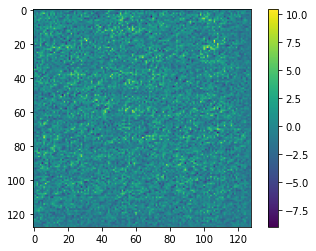

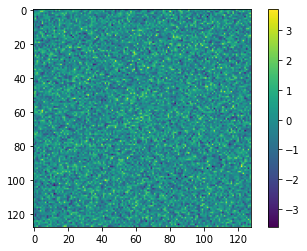

In [7]:
gen_img = model.decoder(gen_enc[:, :model.latent_dim]).detach().cpu().numpy()
gen_img.shape

plt.imshow(gen_img[0, 0, :, :])
plt.colorbar()
plt.show()
plt.imshow(z[0, 0, :, :].detach().cpu().numpy())
plt.colorbar()
plt.show()

[Epoch 5/5] [Batch 0/312] [Loss: 322.791]	]	

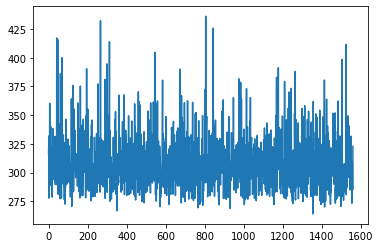

In [182]:
model.train(n_epochs=5, dataLoader=train_dataLoader, lr=1e-6)

In [119]:
model.train(n_epochs=15, dataLoader=train_dataLoader, lr=1e-5)


[Epoch 1/15] [Batch 118/312] [Loss: 295.800]	

KeyboardInterrupt: 

In [154]:
# model.save_states('./single_3_blob_encoder_3', './single_3_blob_decoder_3') 
    # Model single_3_blob_encoder_2 is saved

In [8]:
try:
    model.encoder.load_state_dict(torch.load('./single_3_blob_encoder_3', map_location=model.device))
    model.decoder.load_state_dict(torch.load('./single_3_blob_decoder_3', map_location=model.device))
except Exception:
    print("Failed to load states")

In [9]:
def reduce_resolution(image, scale_factor):
    width = int(image.shape[1] / scale_factor)
    height = int(image.shape[0] / scale_factor)
    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)
    return resized_image

In [10]:
def sharpen_image(image, strength):
    # Create a sharpening kernel
    kernel = np.array([[-strength, -strength, -strength],
                       [-strength, 1 + 8 * strength, -strength],
                       [-strength, -strength, -strength]])
    
    # Apply the sharpening kernel to the image
    sharpened_image = cv2.filter2D(image, -1, kernel)
    
    return sharpened_image

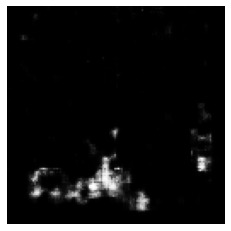

In [12]:
z = torch.normal(mean = 0., std=1.0, size=(BATCH_SIZE, model.latent_dim)).to(model.device)
with torch.no_grad():
    gen_img = model.decode(z, apply_sigmoid=True)[0, 0, :, :].detach().cpu().numpy()

# gen_img = cv2.GaussianBlur(gen_img, (5,5), 0)
# gen_img = reduce_resolution(gen_img, scale_factor=4)

gen_img = gen_img - np.min(gen_img)
gen_img = gen_img / np.max(gen_img)

plt.imshow((gen_img), cmap='Greys_r')
# plt.colorbar()
plt.axis('off')
plt.show()
# print(gen_img)

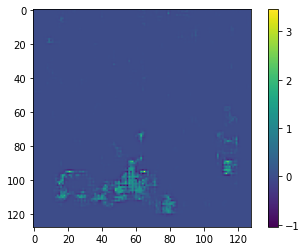

In [13]:
plt.imshow(sharpen_image((gen_img)-np.min(gen_img), 0.5))
plt.colorbar()
plt.show()

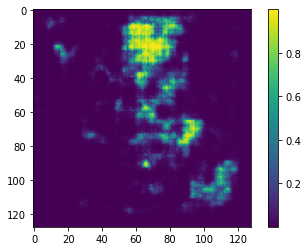

In [14]:
gen_imgs_2 = nn.Sigmoid()(model.sample())[0, 0, :, :].detach().cpu().numpy()
plt.imshow((gen_imgs_2))
plt.colorbar()
plt.show()

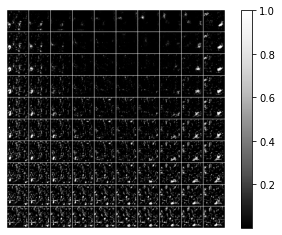

tensor([-1.6449, -1.0364, -0.6745, -0.3853, -0.1257,  0.1257,  0.3853,  0.6745,
         1.0364,  1.6449]) tensor([-1.6449, -1.0364, -0.6745, -0.3853, -0.1257,  0.1257,  0.3853,  0.6745,
         1.0364,  1.6449])


In [30]:
def plot_latent_images(model, n=5, epoch=10, im_size=128+2, save=False):
    img_w = im_size * n
    img_h = im_size * n

    image = np.zeros((img_h, img_w))

    norm = torch.distributions.Normal(0, 1)
    grid_x = norm.icdf(torch.linspace(0.05, 0.95, n))
    grid_y = norm.icdf(torch.linspace(0.05, 0.95, n))

    # print(grid_x.shape)

    for i, y_i in enumerate(grid_x):
        for j, x_j in enumerate(grid_y):
            z = torch.tensor([[x_j, y_i]])
            z = torch.cat([z, torch.normal(0., 1., size=(1, (model.latent_dim-2)))], dim=1).to(device=model.device)
            # print(z.shape)
            x_decoded = model.decode(z=z, apply_sigmoid=True)

            digit = x_decoded[0].view(im_size-2, im_size-2).detach().cpu().numpy()
            digit = np.pad(digit, ((1,1), (1,1)), mode='constant', constant_values=1)
            # plt.imshow(digit)
            # plt.show()

            # digit = digit - np.min(digit)
            # digit = digit / np.max(digit)

            # print(np.max(digit), np.min(digit))

            image[i * im_size:(i+1)*im_size, j*im_size:(j+1)*im_size] = digit

    plt.imshow((image), cmap='Greys_r')
    plt.axis('off')
    plt.colorbar()
    plt.show()


    print(grid_x, grid_y)
plot_latent_images(model, n=10)

tensor([[0.3800, 0.0000]], device='cuda:0')


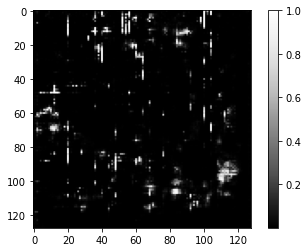

In [31]:
z = torch.ones((1, model.latent_dim)).to(device=model.device)*0.
z[:, 0] = 0.38
print(z)
img = model.decode(z, apply_sigmoid=True)[0, 0, :, :].detach().cpu().numpy()
plt.imshow(img, cmap='Greys_r')
plt.colorbar()
plt.show()

In [17]:
import bin.saving_datasets_for_Statistician as dataset_creator
dataset_creator.create_GAN_dataset(model=model, BATCHES_TO_SAVE = 3, BATCH_SIZE = 10)

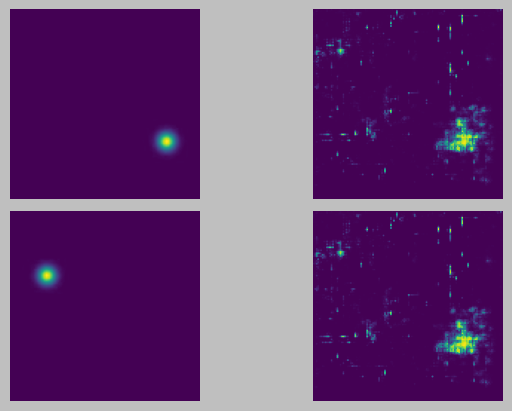

-----FIRST_IMAGE------
Mean: tensor([[ 1.0522, -0.8518]], device='cuda:0', grad_fn=<SliceBackward0>)
Variance: tensor([[7.1264e-05, 8.0656e-05]], device='cuda:0', grad_fn=<ExpBackward0>)
Sampled: tensor([[ 1.0476, -0.8533]], device='cuda:0', grad_fn=<AddBackward0>)
-----SECOND_IMAGE------
Mean: tensor([[ 1.0522, -0.8518]], device='cuda:0', grad_fn=<SliceBackward0>)
Variance: tensor([[7.1264e-05, 8.0656e-05]], device='cuda:0', grad_fn=<ExpBackward0>)
Sampled: tensor([[ 1.0562, -0.8407]], device='cuda:0', grad_fn=<AddBackward0>)


In [35]:
# Comparing the input and generated images from the encoded distribution side-by-side

RESOLUTION_SCALE_FACTOR = 1
real_i, _ = next(iter(train_dataLoader))
real_i = real_i.detach().cpu()
real_i.shape

real_1 = real_i.numpy()[0:1, 0:1, :, :]
real_2 = real_i.numpy()[16:17, 0:1, :, :]

fig = plt.figure(constrained_layout = True, dpi=100,facecolor='0.75')

plt.subplot(2,2,1)
plt.imshow(real_1[0, 0, :, :])
plt.axis('off')

z_1_m, z_1_v = model.encode(torch.tensor(real_1).to(model.device))

z_1 = model.reparameterize(z_1_m, z_1_v)
gene_1 = nn.Sigmoid()(model.decoder(z_1)).detach().cpu().numpy()[0, 0, :, :]
gene_1 = reduce_resolution(gene_1, scale_factor=RESOLUTION_SCALE_FACTOR)

plt.subplot(2,2,2)
plt.imshow(gene_1)
plt.axis('off')


plt.subplot(2,2,3)
plt.imshow(real_2[0, 0, :, :])
plt.axis('off')

z_2_m, z_2_v = model.encode(torch.tensor(real_1).to(model.device))
z_2 = model.reparameterize(z_2_m, z_2_v)
gene_2 = nn.Sigmoid()(model.decoder(z_2)).detach().cpu().numpy()[0, 0, :, :]
gene_2 = reduce_resolution(gene_2, scale_factor=RESOLUTION_SCALE_FACTOR)

plt.subplot(2,2,4)
plt.imshow(gene_2)
plt.axis('off')
plt.show()

print("-----FIRST_IMAGE------")
print("Mean:", z_1_m)
print("Variance:", torch.exp(z_1_v))
print("Sampled:", z_1)
print("-----SECOND_IMAGE------")
print("Mean:", z_2_m)
print("Variance:", torch.exp(z_2_v))
print("Sampled:", z_2)


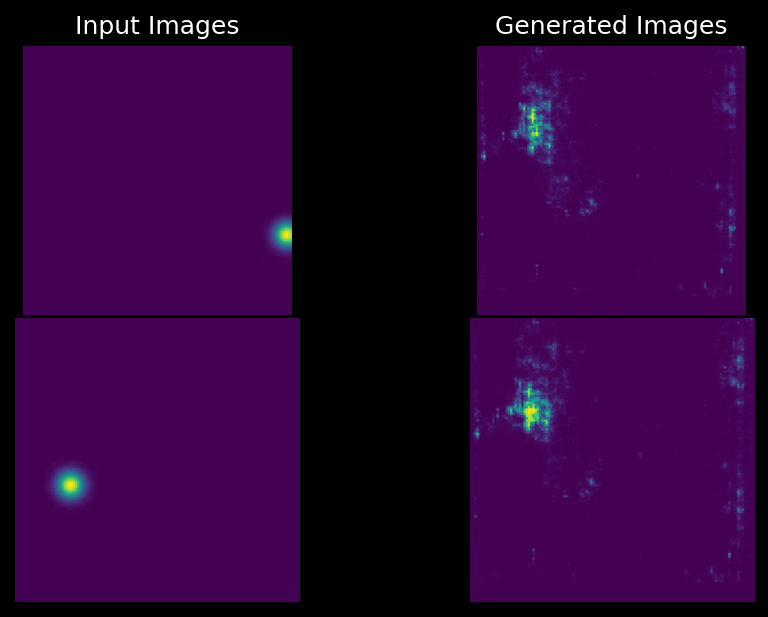

In [317]:
plt.figure(constrained_layout = True, dpi=150, facecolor='0.')
plt.subplot(2,2,1)
plt.title("Input Images", color='white')
plt.imshow(real_1[0, 0, :, :])
plt.axis('off')

plt.subplot(2,2,2)
plt.title("Generated Images", color='white')
plt.imshow(gene_1)
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(real_2[0, 0, :, :])
# plt.title("Input Image")
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(gene_2)
# plt.title("Generated Image")
plt.axis('off')
plt.show()

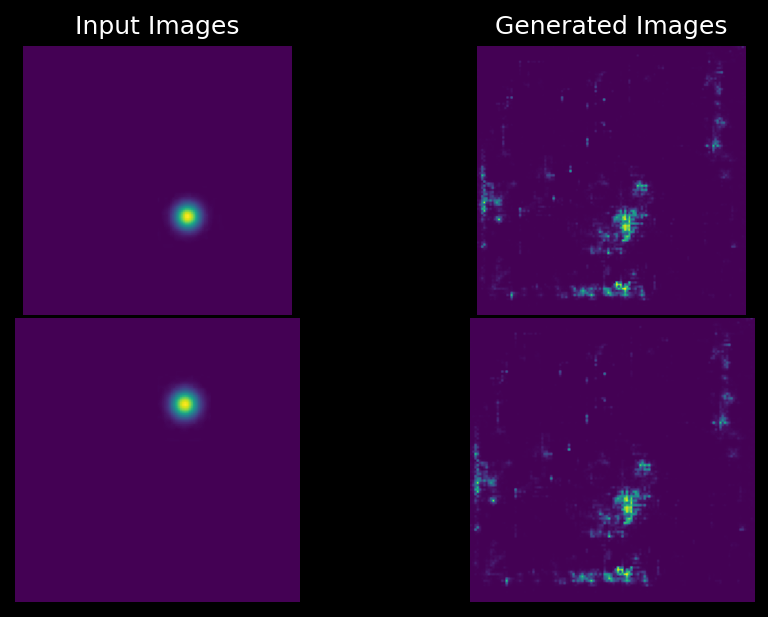

In [44]:
plt.figure(constrained_layout = True, dpi=150, facecolor='0.')
plt.subplot(2,2,1)
plt.title("Input Images", color='white')
plt.imshow(real_1[0, 0, :, :])
plt.axis('off')

plt.subplot(2,2,2)
plt.title("Generated Images", color='white')
plt.imshow(gene_1)
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(real_2[0, 0, :, :])
# plt.title("Input Image")
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(gene_2)
# plt.title("Generated Image")
plt.axis('off')
plt.show()

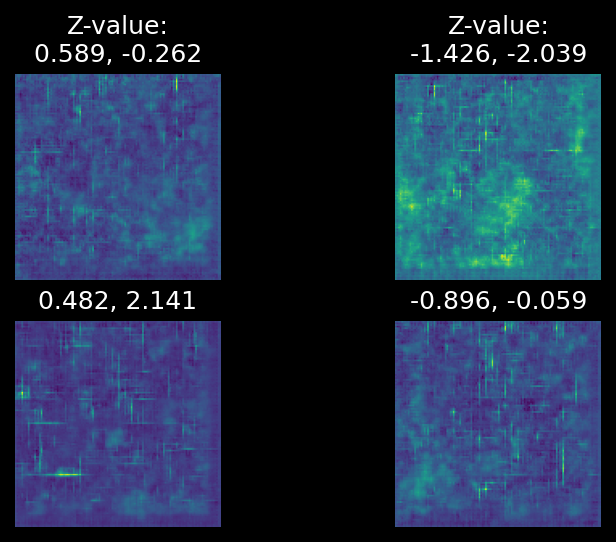

In [66]:
z_fake_1 = torch.normal(0., 1., size=(1, (model.latent_dim))).to(device=model.device)
z_fake_2 = torch.normal(0., 1., size=(1, (model.latent_dim))).to(device=model.device)
z_fake_3 = torch.normal(0., 1., size=(1, (model.latent_dim))).to(device=model.device)
z_fake_4 = torch.normal(0., 1., size=(1, (model.latent_dim))).to(device=model.device)

gene_fake_1 = (model.sample(z_fake_1)).detach().cpu().numpy()[0, 0, :, :]
gene_fake_2 = (model.sample(z_fake_2)).detach().cpu().numpy()[0, 0, :, :]
gene_fake_3 = (model.sample(z_fake_3)).detach().cpu().numpy()[0, 0, :, :]
gene_fake_4 = (model.sample(z_fake_4)).detach().cpu().numpy()[0, 0, :, :]

plt.figure(constrained_layout = False, dpi=150, facecolor='0.')
plt.subplot(2,2,1)
plt.title(f'Z-value:\n{z_fake_1.detach().cpu().numpy()[0,0]:.3f}, {z_fake_1.detach().cpu().numpy()[0,1]:.3f}', color='white')
plt.imshow(gene_fake_1)
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(gene_fake_2)
plt.title(f'Z-value:\n{z_fake_2.detach().cpu().numpy()[0,0]:.3f}, {z_fake_2.detach().cpu().numpy()[0,1]:.3f}', color='white')
plt.axis('off')

plt.subplot(2,2,3)
plt.title(f'{z_fake_3.detach().cpu().numpy()[0,0]:.3f}, {z_fake_3.detach().cpu().numpy()[0,1]:.3f}', color='white')
plt.imshow(gene_fake_3)
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(gene_fake_4)
plt.title(f'{z_fake_4.detach().cpu().numpy()[0,0]:.3f}, {z_fake_4.detach().cpu().numpy()[0,1]:.3f}', color='white')
plt.axis('off')

plt.show()


Cos(theta): [[0.]]
Theta: 1.5707973705062865


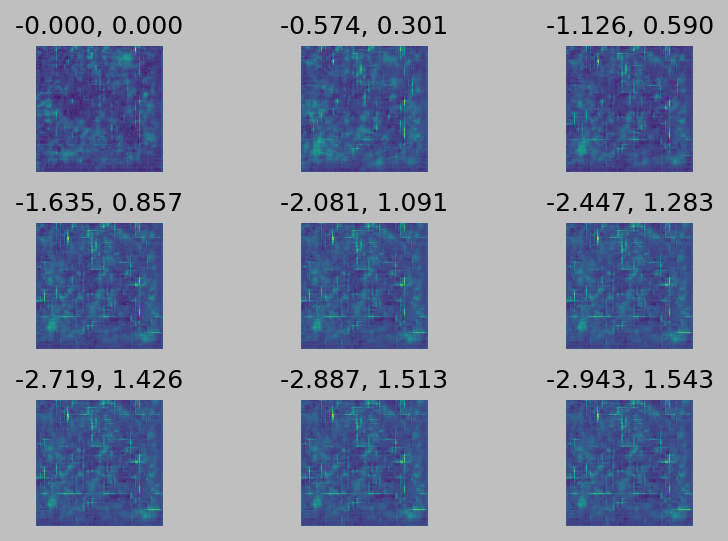

In [117]:
# Trying to interpolate between images
# Comparing the input and generated images from the encoded distribution side-by-side

RESOLUTION_SCALE_FACTOR = 1
# real_i, _ = next(iter(train_dataLoader))
# real_i = real_i.detach().cpu()
# real_i.shape

# real_1 = real_i.numpy()[0:1, 0:1, :, :]
# real_2 = real_i.numpy()[16:17, 0:1, :, :]

# z_1_m, z_1_v = model.encode(torch.tensor(real_1).to(model.device))
# z_2_m, z_2_v = model.encode(torch.tensor(real_1).to(model.device))

z_1_m = torch.normal(0., 1., size=(1, (model.latent_dim))).to(device=model.device)*0.
z_2_m = torch.normal(0., 1., size=(1, (model.latent_dim))).to(device=model.device)

fig = plt.figure(dpi=150,facecolor='0.75')

plt.subplot(3,3,1)
plt.title(f'{z_1_m[0, 0]:.3f}, {z_1_m[0, 1]:.3f}')
plt.imshow((model.sample(z_1_m)).detach().cpu().numpy()[0, 0, :, :])
plt.axis('off')


plt.subplot(3,3,9)
plt.title(f'{z_2_m[0, 0]:.3f}, {z_2_m[0, 1]:.3f}')
plt.imshow((model.sample(z_2_m)).detach().cpu().numpy()[0, 0, :, :])
plt.axis('off')

z_1_m = z_1_m.detach().cpu().numpy()
z_2_m = z_2_m.detach().cpu().numpy()

theta = z_1_m @ z_2_m.T / ((np.linalg.norm(z_1_m[0, :]) + 1e-6) * (np.linalg.norm(z_2_m[0, :]) + 1e-6))
print("Cos(theta):", theta)
theta = np.arccos(theta[0,0]) + 1e-6
print("Theta:", theta)

for i in range(7):
    l = (i + 1) / 8
    
    fac_1 = np.sin((1 - l)*theta) / np.sin(theta)
    fac_2 = np.sin(l * theta) / np.sin(theta)

    z_mid = z_1_m * fac_1 + z_2_m * fac_2
    # print(z_mid)

    gen_img = (model.sample(torch.tensor(z_mid, device=model.device))).detach().cpu().numpy()[0, 0, :, :]
    plt.subplot(3,3,i+2)
    plt.title(f'{z_mid[0, 0]:.3f}, {z_mid[0, 1]:.3f}')
    plt.imshow(gen_img)
    plt.axis('off')





# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

# print("-----FIRST_IMAGE------")
# print("Mean:", z_1_m)
# print("Variance:", torch.exp(z_1_v))
# print("-----SECOND_IMAGE------")
# print("Mean:", z_2_m)
# print("Variance:", torch.exp(z_2_v))


Theta: 0.0


<ipython-input-81-30eac536ebd7>:31: RuntimeWarning: invalid value encountered in double_scalars
  fac_1 = np.sin((1 - l)*theta) / np.sin(theta)
<ipython-input-81-30eac536ebd7>:32: RuntimeWarning: invalid value encountered in double_scalars
  fac_2 = np.sin(l * theta) / np.sin(theta)


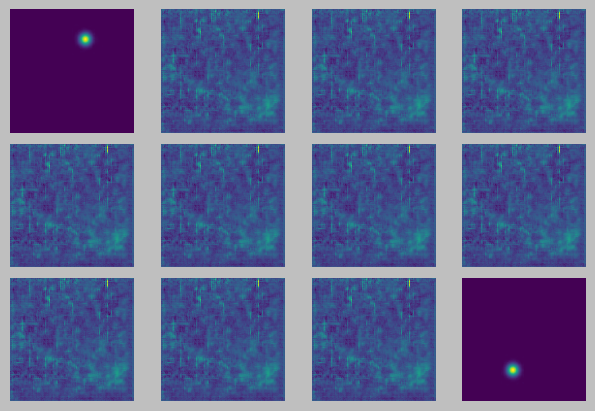

-----FIRST_IMAGE------
Mean: [[ 0.18584862 -0.4224846 ]]
Variance: tensor([[3.0310e-05, 3.1982e-05]], device='cuda:0', grad_fn=<ExpBackward0>)
-----SECOND_IMAGE------
Mean: [[ 0.18584862 -0.4224846 ]]
Variance: tensor([[3.0310e-05, 3.1982e-05]], device='cuda:0', grad_fn=<ExpBackward0>)


In [81]:
# Trying to interpolate between images
# Comparing the input and generated images from the encoded distribution side-by-side

RESOLUTION_SCALE_FACTOR = 1
real_i, _ = next(iter(train_dataLoader))
real_i = real_i.detach().cpu()
real_i.shape

real_1 = real_i.numpy()[0:1, 0:1, :, :]
real_2 = real_i.numpy()[16:17, 0:1, :, :]

z_1_m, z_1_v = model.encode(torch.tensor(real_1).to(model.device))
z_2_m, z_2_v = model.encode(torch.tensor(real_1).to(model.device))

fig = plt.figure(constrained_layout = True, dpi=100,facecolor='0.75')

plt.subplot(3,4,1)
plt.imshow(real_1[0, 0, :, :])
plt.axis('off')

z_1_m = z_1_m.detach().cpu().numpy()
z_2_m = z_2_m.detach().cpu().numpy()

theta = z_1_m @ z_2_m.T / (np.linalg.norm(z_1_m[0, :]) * np.linalg.norm(z_2_m[0, :]))
theta = np.arccos(theta[0,0])
print("Theta:", theta)

for i in range(10):
    l = (i + 1) / 11
    
    fac_1 = np.sin((1 - l)*theta) / np.sin(theta)
    fac_2 = np.sin(l * theta) / np.sin(theta)

    z_mid = z_1_m * fac_1 + z_2_m * fac_2

    gen_img = (model.sample(z_fake_1)).detach().cpu().numpy()[0, 0, :, :]
    plt.subplot(3,4,i+2)
    plt.imshow(gen_img)
    plt.axis('off')



plt.subplot(3,4,12)
plt.imshow(real_2[0, 0, :, :])
plt.axis('off')
plt.show()

print("-----FIRST_IMAGE------")
print("Mean:", z_1_m)
print("Variance:", torch.exp(z_1_v))
print("-----SECOND_IMAGE------")
print("Mean:", z_2_m)
print("Variance:", torch.exp(z_2_v))
